In [47]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers, models, datasets, callbacks, optimizers, losses, metrics
import tensorflow.keras.backend as K

from scipy.stats import norm

In [48]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

In [49]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [50]:
def preprocess(imgs):
    '''
    Normalize and reshape dataset images
    '''
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0,0), (2,2), (2,2)), constant_values = 0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

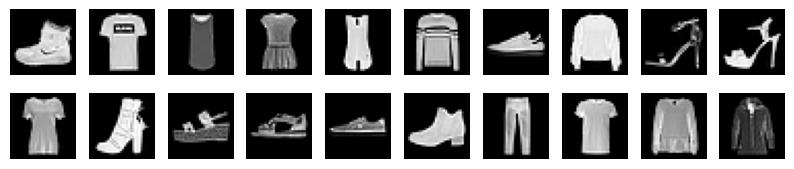

In [44]:
plt.figure(figsize=(10,2))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_train[i, :, :, 0], cmap="gray")
    plt.axis("off")
plt.show()

In [51]:
# Subclassing the Layer class to define how a tensor is to be modified by the new layer
class Sampling(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [27]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_13 (Conv2D)          (None, 8, 8, 64)             18496     ['conv2d_12[0][0]']           
                                                                                                  
 conv2d_14 (Conv2D)          (None, 4, 4, 128)            73856     ['conv2d_13[0][0]']           
                                                                                            

In [32]:
# Decoder

decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3,3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, (3,3), strides=2, padding="same", activation="relu")(x)
decoder_output = layers.Conv2D(
    1,
    (3,3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_4 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_12 (Conv2  (None, 8, 8, 128)         147584    
 DTranspose)                                                     
                                                                 
 conv2d_transpose_13 (Conv2  (None, 16, 16, 64)        73792     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_14 (Conv2  (None, 32, 32, 32)        1846

In [38]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [39]:
vae = VAE(encoder, decoder)

In [40]:
# We are using a custom loss function the KL divergence
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

# Create the model and save checkpoints
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./vae_checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [ ]:
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test,x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback]
)

In [ ]:
vae.save("./models_vae")
encoder.save("./models_vae/encoder")
decoder.save("./models_vae/decoder")

In [ ]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [55]:
# Print some examples of the embeddings
z_mean, z_log_var, z = encoder.predict(example_images)
print(z[:10])

157/157 [==============================] - 2s 8ms/step
[[-0.15875824  1.2600853 ]
 [-0.91833985 -0.83431244]
 [ 2.0512369  -1.3568841 ]
 [ 2.068738   -0.4243441 ]
 [-0.25820482 -0.21733457]
 [ 1.1013626  -0.9807028 ]
 [ 0.56081545  0.03346882]
 [-0.19297141 -0.2545366 ]
 [ 1.3566529   2.103643  ]
 [-0.05204751  2.2699413 ]]


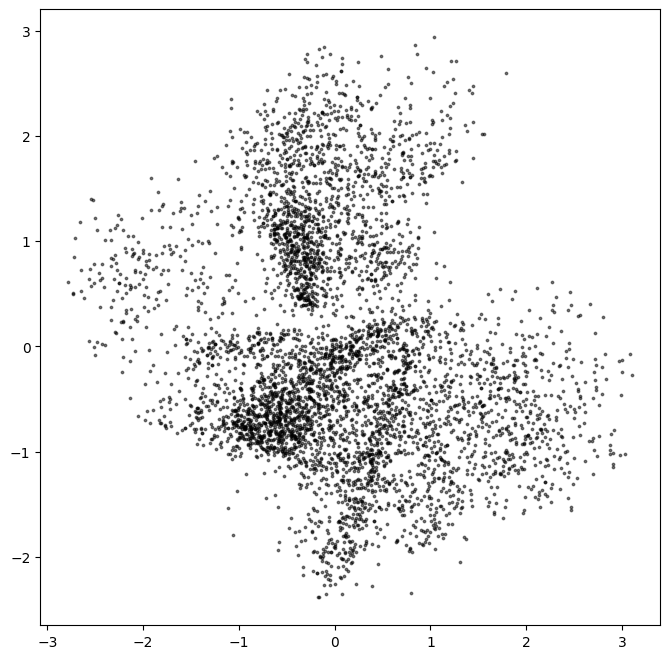

In [59]:
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

In [62]:
grid_width, grid_height=(6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [63]:
# Decode samples
reconstructions = decoder.predict(z)

157/157 [==============================] - 3s 17ms/step


In [65]:
# Convert original embeddings and sampled embeddings to p-values, i.e. determines the probability of seeing the value <= to z
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)
p_sample

array([[0.40151737, 0.88013317],
       [0.78069964, 0.84343544],
       [0.74289485, 0.78702733],
       [0.46835969, 0.62566288],
       [0.29432595, 0.00629389],
       [0.67758637, 0.04289077],
       [0.24125799, 0.37650483],
       [0.78327744, 0.41729389],
       [0.32215919, 0.23764166],
       [0.16931268, 0.79129496],
       [0.95412631, 0.0036959 ],
       [0.23777035, 0.21737877],
       [0.69798973, 0.24609377],
       [0.63908825, 0.86677703],
       [0.26717504, 0.19154807],
       [0.04546978, 0.29512816],
       [0.78406131, 0.11864005],
       [0.67111173, 0.85244694]])

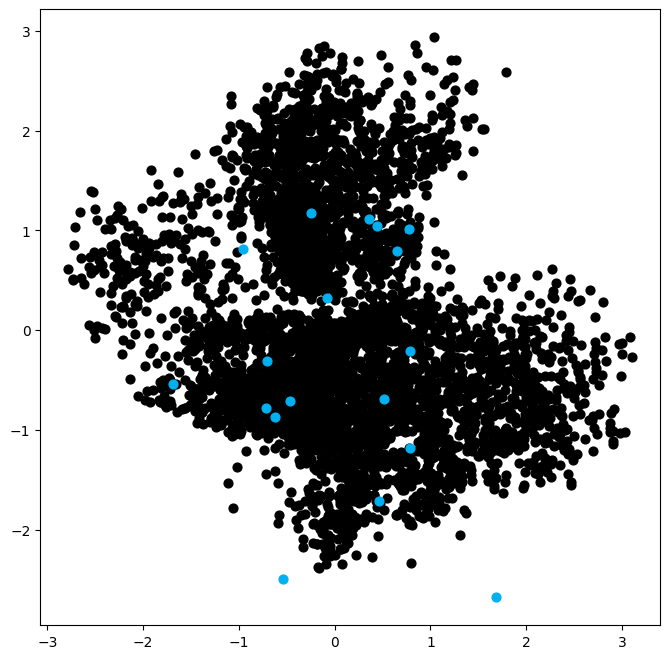

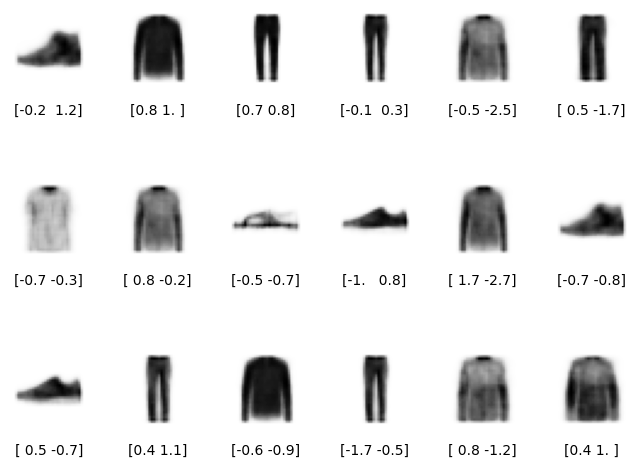

In [69]:
figsize = 8
plt.figure(figsize=(figsize, figsize))

plt.scatter(z[:, 0], z[: ,1], c="black", alpha=1, s=40)

plt.scatter(z_sample[: ,0], z_sample[:, 1], c="#00B0F0", s=40, alpha=1)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

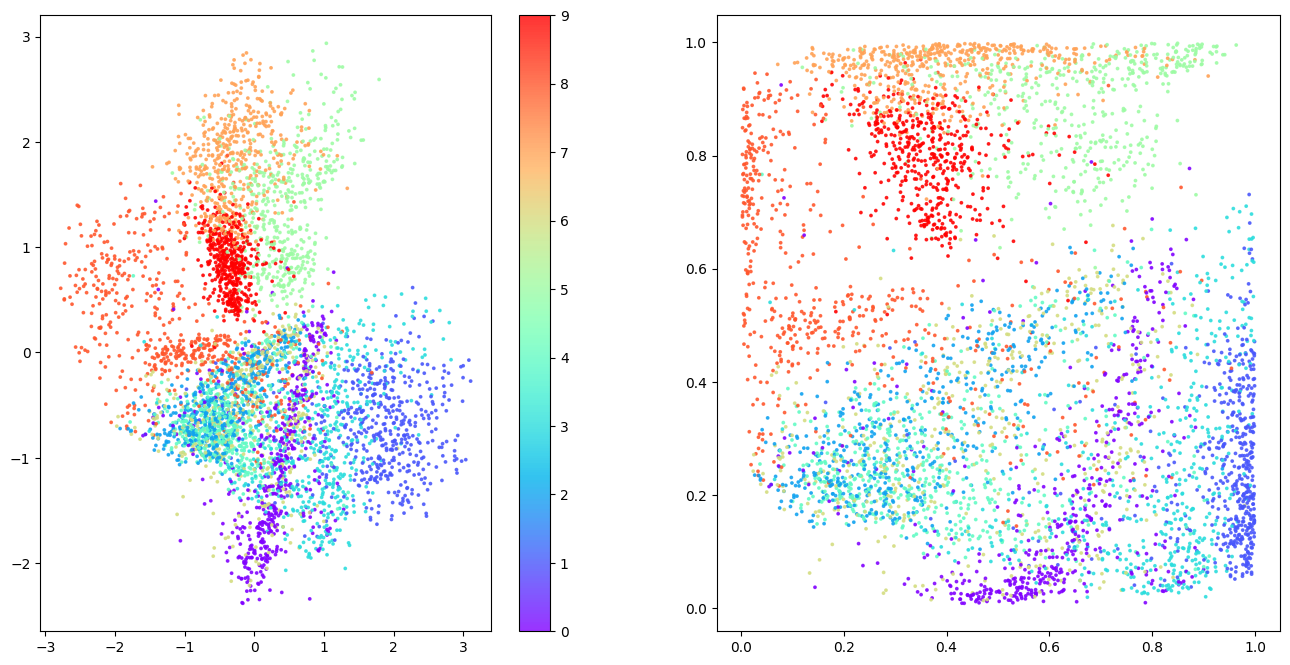

In [75]:
# View the latent space
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1 ,2, 1)
plot_1 = plt.scatter(z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plt.scatter(p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3)
plt.show()
